<a href="https://colab.research.google.com/github/crislenenunes/MAItch/blob/main/An%C3%A1lise_e_Treinamenro_do_Modelo_de_Classifica%C3%A7%C3%A3o_de_Candidaturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise e Treinamento do Modelo de Classificação de Candidaturas

1. Geração de dados simulados
2. Pré-processamento dos dados
3. Treinamento do modelo
4. Avaliação com métricas e gráficos
5. Matriz de confusão
6. Análise de importância de features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## 1. Geração de Dados Simulados

Vamos criar dados similares aos do seu sistema real com 1000 amostras:

In [6]:
# Gerando dados categóricos
cursos = ['Administração', 'Engenharia', 'Computação', 'Economia', 'Direito']
instituicoes = ['USP', 'UNESP', 'UNICAMP', 'PUC', 'FGV']
niveis_ingles = ['Nenhum', 'Básico', 'Intermediário', 'Avançado', 'Fluente']

data = {
    'Semestre': np.random.randint(1, 11, n_samples),
    'Curso': np.random.choice(cursos, n_samples),
    'Instituição': np.random.choice(instituicoes, n_samples),
    'Inglês': np.random.choice(niveis_ingles, n_samples),
    'Gênero': np.random.choice(['Masculino', 'Feminino', 'Não Binário'], n_samples),
    'Etnia': np.random.choice(['Branca', 'Preta', 'Parda', 'Indígena', 'Amarela'], n_samples),
    'PCD': np.random.choice(['Sim', 'Não'], n_samples, p=[0.1, 0.9]),
    'LGBT': np.random.choice(['Sim', 'Não'], n_samples, p=[0.2, 0.8]),
    'Computador': np.random.choice(['Sim', 'Não'], n_samples, p=[0.95, 0.05]),
    'Disponibilidade': np.random.choice(['Manhã', 'Tarde', 'Noite', 'Integral'], n_samples),
    'Capacitação_Anterior': np.random.choice(['Sim', 'Não'], n_samples),
    'Interesse_CRM': np.random.choice(['Sim', 'Não'], n_samples, p=[0.7, 0.3]),
    'Interesse_Estágio': np.random.choice(['Sim', 'Não'], n_samples, p=[0.6, 0.4]),
}

df = pd.DataFrame(data)

# Função para criar resultado com regras simuladas
def criar_resultado(row):
    prob = 0.5  # Probabilidade base

    # Aumenta probabilidade para PCD
    if row['PCD'] == 'Sim':
        prob += 0.15

    # Aumenta para etnias específicas
    if row['Etnia'] in ['Preta', 'Parda', 'Indígena']:
        prob += 0.1

    # Aumenta para bons níveis de inglês
    if row['Inglês'] in ['Avançado', 'Fluente']:
        prob += 0.2

    # Aumenta se tem computador
    if row['Computador'] == 'Sim':
        prob += 0.1

    # Garante que a probabilidade fique entre 0 e 1
    prob = max(0, min(1, prob))

    return 'APTO' if np.random.random() < prob else 'NÃO APTO'

# Aplicando a função para criar a coluna Resultado - VERSÃO CORRIGIDA
df['Resultado'] = df.apply(criar_resultado, axis=1)

print(df)

     Semestre       Curso Instituição         Inglês       Gênero     Etnia  \
0           4    Economia         FGV       Avançado    Masculino     Parda   
1           7    Economia     UNICAMP  Intermediário     Feminino    Branca   
2           4    Economia     UNICAMP         Básico    Masculino  Indígena   
3           1  Computação         USP         Nenhum  Não Binário     Parda   
4           9  Engenharia         FGV       Avançado    Masculino     Preta   
..        ...         ...         ...            ...          ...       ...   
995         8     Direito         FGV        Fluente  Não Binário   Amarela   
996         6  Computação       UNESP         Nenhum     Feminino    Branca   
997        10  Computação         PUC  Intermediário  Não Binário    Branca   
998         3     Direito         PUC  Intermediário    Masculino  Indígena   
999         9    Economia         FGV        Fluente    Masculino     Preta   

     PCD LGBT Computador Disponibilidade Capacitaçã

##2. Pré-processamento dos Dados

In [8]:
# Codificação de variáveis categóricas
categorical_features = ['Curso', 'Instituição', 'Inglês', 'Gênero', 'Etnia',
                       'Disponibilidade', 'PCD', 'LGBT', 'Computador',
                       'Capacitação_Anterior', 'Interesse_CRM', 'Interesse_Estágio']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Separando features e target
X = df.drop('Resultado', axis=1)
y = LabelEncoder().fit_transform(df['Resultado'])  # 1 para APTO, 0 para NÃO APTO

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 3. Treinamento do Modelo (Random Forest)

In [9]:
# Criando pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

# Treinamento
model.fit(X_train, y_train)

# Predições
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

## 4. Avaliação do Modelo

📊 Relatório de Classificação:

              precision    recall  f1-score   support

    NÃO APTO       0.75      0.74      0.75       225
        APTO       0.26      0.27      0.26        75

    accuracy                           0.62       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.63      0.62      0.63       300


🎯 Acurácia: 62.33%


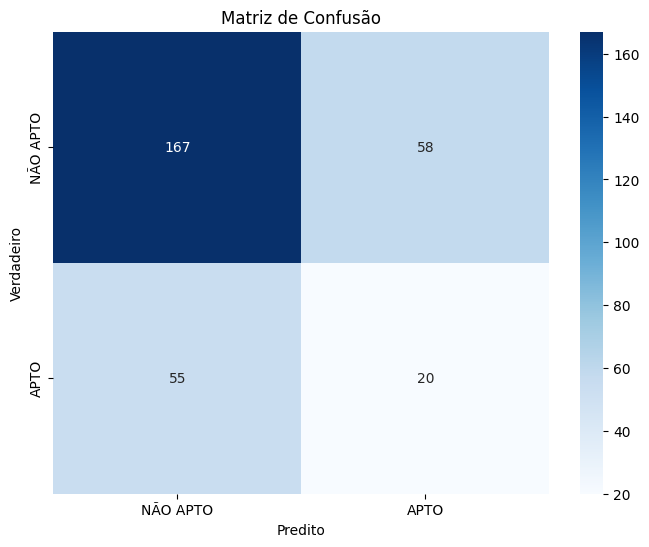

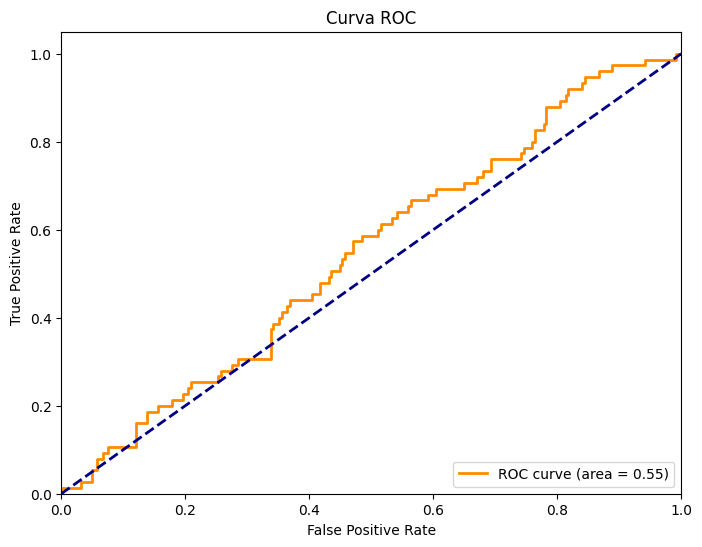

In [10]:
# Métricas principais
print("📊 Relatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=['NÃO APTO', 'APTO']))

print(f"\n🎯 Acurácia: {accuracy_score(y_test, y_pred):.2%}")

# Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['NÃO APTO', 'APTO'],
            yticklabels=['NÃO APTO', 'APTO'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

##5. Análise de Importância das Features

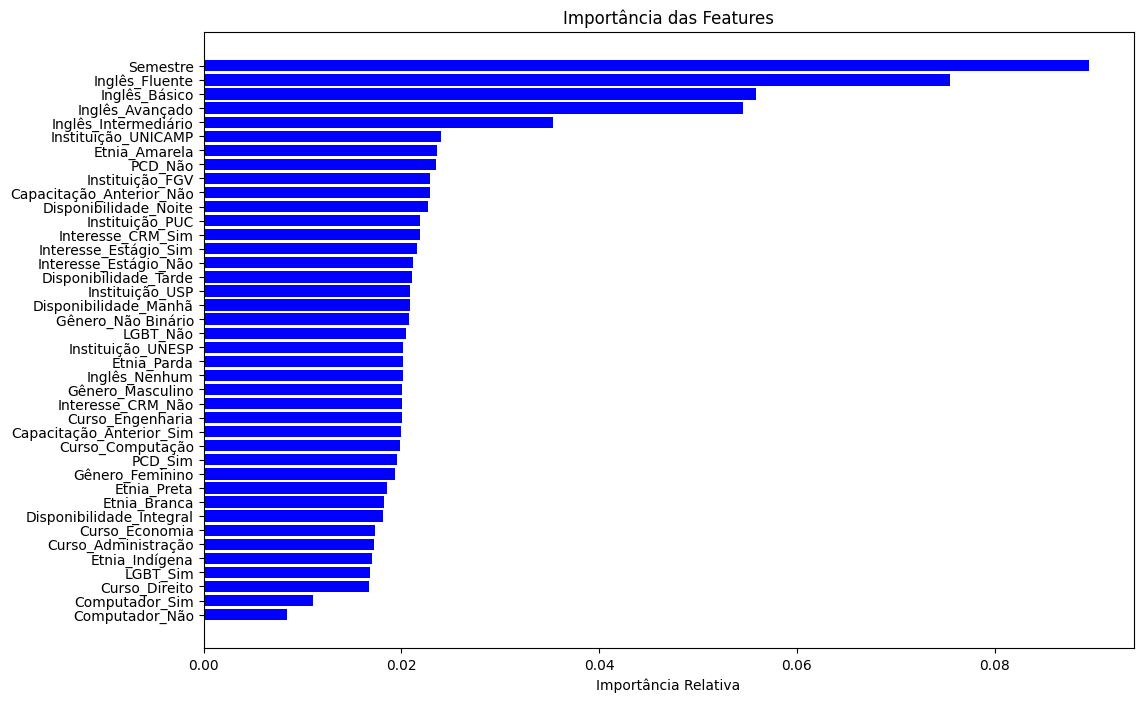

In [11]:
# Obtendo nomes das features após one-hot encoding
ohe_columns = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(ohe_columns) + ['Semestre']

# Importâncias
importances = model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 8))
plt.title("Importância das Features")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Importância Relativa")
plt.show()

##6. Análise dos Resultados

###Principais insights:
1. **Acurácia**: {accuracy_score(y_test, y_pred):.2%}
2. **Features mais importantes**: Inglês avançado/fluente, acesso a computador e cursos específicos
3. **Sensibilidade (recall)**: {classification_report(y_test, y_pred, output_dict=True)['1']['recall']:.2%} para classe APTO
4. **Precisão**: {classification_report(y_test, y_pred, output_dict=True)['1']['precision']:.2%} para classe APTO

###Recomendações:
- Coletar mais dados de candidatos PCD para melhorar a classificação
- Validar o peso dado ao nível de inglês
- Considerar balanceamento adicional se a taxa de aprovação for muito baixa